# Click Through Rate (CTR) Prediction for Advertisement Pricing

## Section 1 - Question Formulation

### 1.0: Goal of the Analysis

The initial goal of our analysis is to build a model to predict ClickThroughRate (CTR), i.e. given a set of features of both an advertisement(advertisment length, type, duration, etc) and a set of features of a user (webpage visited, web-page history), what is the probability that he or she will click on that given advertisement? The larger goal is to build a model that will perform at scale using concepts taught in this class.

### 1.1: What Questions Do We Seek To Answer?

Some of the questions that we seek to answer are:

(1) Which variables are more important in determining the click-through rate prediction?

(2) In addition to Logistic Regression, which we will be exploring for CTR prediction, what improvements and expected accuracy increases can we get by using other Machine Learning techniques? 

(3) How can we expect to scale the eventual predictive modeling approach to the entire 10GB dataset? 

### 1.2: Why Do People Perform This Kind Of Analysis?

Click-through rate (CTR) prediction is critical to many web applications including web search, recommender systems, sponsored search, and display advertising. Search advertising, known as sponsored search, refers to advertisers identifying relevant keywords based on their product or service for advertising. When the user retrieves the keyword purchased by the advertiser, the corresponding advertisement is triggered and displayed. In the cost-per-click model, the advertiser pays the web publisher only when a user clicks their advertisements and visits the advertiser's site. The CTR prediction is defined to estimate the ratio of clicks to impressions of advertisements that will be displayed.

### 1.3: What Level Of Performance Should The Model Have To Achieve Practical Use?

Based on a literature search, the model would have to have an "areaUnderROC" value of close to 75% and a logloss of 0.025 for it to be considered a high-performing model (Wang et al., 2018). Entropy or mutual information is another metric that is useful for CTR prediction algorithms. Juan et al., 2017 used a normalized log loss to measure performance of their model as well as a "Utility" metric which allows to model offline the potential change in profit due to a prediction model change.

### 1.4: An Introduction To The Dataset

In [2]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw5_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [4]:
from pyspark.sql import SQLContext

In [3]:
trainRDD = sc.textFile('s3://breastcancerfile/e-AKVLH55FZCUE4SN1JHTY7DWU4/train.txt')

VBox()

In [5]:
trainRDD = sc.textFile('data/train.txt')

#### 1.4.1: Distribution of the Labels in the Dataset

The code below is used for finding the count of "1"s and "0"s in the entire dataset. The count shows that we have 34,095,179 "0"s (no-clicks) and 11,745,438 "1"s (clicks). The dataset is unbalanced, but not by a lot, so it is not necessary that we do subsampling of the dataset.

In [6]:
def CountNumberLabel(toyRDDLine):
    
    """ Takes the Count of Number of 1 and 0's in the Label for the entire dataset """
    Values = toyRDDLine.split('\t')
    T1 = Values[0]
    return (T1, 1)

trainRDD.map(CountNumberLabel).reduceByKey(lambda x,y: x+y).collect()

[('0', 34095179), ('1', 11745438)]

#### 1.4.2: Training and Testing Dataset From The Original 10GB DataSet

The training dataset was created from the original dataset using the `randomSplit()` function. `randomSplit()` enables us to generate a random subset of any dataset. We decided to go with an 1% split of the dataset that represents a count of 458,906 rows called `TrainRDD` - enough for one to train a Logistic Regression function. The testing dataset was created from the 99% remainder of the split (called `TrainRDD2`). The test dataset was used for validating the weights from the Logistic Regression Model used as a model for click prediction.

In [8]:
TrainRDD, TrainRDD2 = trainRDD.randomSplit([0.01,0.99], seed = 2018)

Prior to doing exploratory data analysis, we needed to know what the distribution of the number of clicks (1) and no-clicks (0) were in the entire dataset. This enabled us to understand if we have an unbalanced dataset and if subsampling of the dataset would be necessary to ensure that we have an even distribution between the features. 

In [9]:
TestRDD2, TestRDD = TrainRDD2.randomSplit([0.001,0.999], seed = 2018)

The count of the number of rows of data in the Train and Test dataset is shown below. 458,455 rows are present in the TrainRDD while 45,355 are present in the TestRDD dataset.

In [10]:
print("The number of rows in the training dataset: ", TrainRDD.count())

The number of rows in the training dataset:  458455


In [11]:
print("The number of rows in the test dataset: ", TestRDD2.count())

The number of rows in the test dataset:  45355


#### 1.4.3: Dataset Contents and Context

The dataset consists of 14 numeric columns or features and 25 categorical columns or features. The first numerical column in the dataset represents the binary "Yes"/"No" click event represented as either a "1" or a "0" respectively. 

To better understand the dataset, we divided the dataset exploratory section into a numerical exploratory section and a categorical exploratory section. 

In the numerical exploratory section, our main goals were to:

(1) Find the minimum and maximum values of each numerical feature in the column(s) from 1-14.

(2) Find the mean and standard deviation of each of the numerical features contained in the entire dataset.

The distribution within each dataset is discussed in the Exploratory Data Analysis section.

The questions we intended to investigate in the numerical data introduction section were:

(1) What were the types of Labels and what was the the distribution of the Labels ("1" and "0")? 
- The ratio of "1"s to "0"s, i.e., clicks to no-clicks, was shown to be roughly 1:3 (see Section 1.0 above), indicating an unbalanced dataset but not severely unbalanced.

(2) What were the minimum and maximum values of all the numerical features within each numerical column? 
- This can be done by going through the entire dataset. This is a computationally expensive process but is required. The values need to be saved into an array since the resultant matrix can easily be saved to disk/cached so that we do not have to compute that every time.

(3) What were the means and standard deviations of the numerical features within each numerical column? 
- This is also a computationally expensive process, but the resultant matrix can also be saved to disk/cached so that computation is only done once.

**Some Core Course Concepts Utilized in this Section**:

*Caching and Broadcasting the Matrix containing Mean and Standard Deviations* -- Finding the mean and standard deviation for the trainRDD (10GB dataset) involves going through the entire dataset. However, mean and standard deviation are supposed to be utilized for mean-normalizing only the TrainRDD and the TestRDD2. Thus an important concept here is to *first* do the mean and standard deviation calculation and then *cache* these values. Because the matrix of the mean and standard deviation is small, one can broadcast these values without incurring much performance penalty for use in mean-normalizing the TrainRDD and the TestRDD2.

*Mean Normalization for SGD* -- Mean normalization of the numerical variables is very important for Gradient Descent because non-normalized features would take a longer time to converge. To ensure that we converge faster we use mean normalization of the features using the array of mean and standard deviation values.

In [12]:
def ExtractNumerals(toyRDDline):
    
    YY = toyRDDline.split('\t')
    
    if YY[ii] == '':   ## There are empty values/NaNs - They are replaced with 0's for this initial Mean, StdDev calculation
        ReturnValue = 0
    else:
        ReturnValue = float(YY[ii])
    return ReturnValue

In [14]:
Node = []
NodeMeanMax = []
    
for ii in range(1,14):

    featureRDD = trainRDD.map(ExtractNumerals)\
                         .cache()
    featureMeans = featureRDD.mean()
    featureStdev = np.sqrt(featureRDD.variance())
    
    featureMax = featureRDD.max()
    featureMin = featureRDD.min()
    
    Node.append((featureMeans, featureStdev))
    NodeMeanMax.append((featureMax, featureMin))

In [16]:
Node

[(1.9136993727636809, 7.184627898705608),
 (105.84841979766556, 391.45781841729996),
 (21.13629851448115, 352.8574390110648),
 (5.735263227368864, 8.346464252535688),
 (18060.51214960742, 68556.28645274039),
 (90.10443053155232, 340.53335300283976),
 (15.62662976373116, 64.6908374702787),
 (12.510823839914709, 16.68706965443228),
 (101.51997332409383, 216.54476824937402),
 (0.33741472109766746, 0.59176564119444),
 (2.6146237734976343, 5.115681630473718),
 (0.2328159762771082, 2.7454850748632738),
 (6.436072751813085, 14.741644511057435)]

In [17]:
Needed = sc.broadcast(Node)

In [18]:
NodeMeanMax

[(5775.0, 0),
 (257675.0, -3.0),
 (65535.0, 0),
 (969.0, 0.0),
 (23159456.0, 0.0),
 (431037.0, 0),
 (56311.0, 0.0),
 (6047.0, 0.0),
 (29019.0, 0.0),
 (11.0, 0),
 (231.0, 0.0),
 (4008.0, 0),
 (7393.0, 0)]

In [19]:
NodeMeanMax = [(5775.0, 0),
 (257675.0, -3.0),
 (65535.0, 0),
 (969.0, 0.0),
 (23159456.0, 0.0),
 (431037.0, 0),
 (56311.0, 0.0),
 (6047.0, 0.0),
 (29019.0, 0.0),
 (11.0, 0),
 (231.0, 0.0),
 (4008.0, 0),
 (7393.0, 0)]

In [20]:
NodeMeans = [(1.9136993727636809, 7.184627898705608),
 (105.84841979766556, 391.45781841729996),
 (21.13629851448115, 352.8574390110648),
 (5.735263227368864, 8.346464252535688),
 (18060.51214960742, 68556.28645274039),
 (90.10443053155232, 340.53335300283976),
 (15.62662976373116, 64.6908374702787),
 (12.510823839914709, 16.68706965443228),
 (101.51997332409383, 216.54476824937402),
 (0.33741472109766746, 0.59176564119444),
 (2.6146237734976343, 5.115681630473718),
 (0.2328159762771082, 2.7454850748632738),
 (6.436072751813085, 14.741644511057435)]

Needed = sc.broadcast(NodeMeans)

#### 1.4.4: Mean-Normalization of the Numerical Variable -- TrainRDD

As discussed above, mean-normalization of the numerical variable is key to enabling fast gradient descent optimization.
We can mean normalize the dataset by splitting the data into Numerical and Categorical variables and then working only on the numerical variable in this section. 
However, that would result to creating additional data and that is O(space) inefficient. A better idea to cater to scalability would be to work with the dataset as is and make modifications to the dataset. This would lead to an O(1) space complexity and thus enable faster computation of the mean normalization. 
Recall, we are broadcasting the Mean and Standard deviation array to all the partitions for computing the mean-normalization. This computation process has  O(n) time complexity and O(1) space complexity, while is ideal for scaling and also ideal for use in a map-reduce paradigmn or environment since it now represents an embarassingly parallel computation.

During the computation of the mean normalization, we are also replacing all NaN or empty values with the calculated mean for that numerical column and replacing all the NaN or empty values with 0 for the categorical columns. 

In [21]:
def NumericValuesOnly(LineRDD):
    """Function takes the RDD Mean normalizes the Numerical Column in the RDD and replaces 'NAN' and '' with mean for 
       Numerical values and '0' for Categorical values"""
    
    Node = Needed.value
    Values = LineRDD.split('\t')
    ZZ = []
    for ii in range(0,40):
        
        if ii < 14:
            if Values[ii] == '':
                ZZ.append(Node[ii-1][0])
            else:
                if (ii == 0):
                    ZZ.append(float(Values[ii]))
                else:
                    ZZ.append((float(Values[ii])- float(Node[ii-1][0]))/float(Node[ii-1][1]))
        else:
            if Values[ii] == '':
                ZZ.append(str(0))
            else:
                ZZ.append(str(Values[ii]))
    
    return (((str(Values[14])+ str(Values[15]) + str(Values[16])), ZZ))

In [23]:
NonNumericRDD = TrainRDD.map(NumericValuesOnly).cache()
NonNumericRDD.take(5)

[('68fd1e64287130e071e126ad',
  [0.0,
   -0.26636026245819294,
   -0.2729500211023082,
   0.00811574638625955,
   -0.6871488397768515,
   -0.052139815829603434,
   0.9217762862301186,
   -0.1488097872925819,
   -0.6298783463831777,
   -0.24253632977921483,
   -0.5701830211308282,
   -0.12014503987823798,
   0.2328159762771082,
   -0.3009211589986225,
   '68fd1e64',
   '287130e0',
   '71e126ad',
   '7846ae91',
   '4cf72387',
   '6f6d9be8',
   'f6ce794a',
   '0b153874',
   'a73ee510',
   '70962768',
   'ab066900',
   'e95d3160',
   '5d4198ed',
   'f7c1b33f',
   '42793602',
   'fc877894',
   'e5ba7672',
   '891589e7',
   '55dd3565',
   'a458ea53',
   'c8d017f7',
   '0',
   '32c7478e',
   '7d290d33',
   'c243e98b',
   '71848e87']),
 ('68fd1e64083aa75b',
  [0.0,
   1.9136993727636809,
   -0.2652863601435636,
   -0.03722834511098185,
   0.9902081315594536,
   -0.09341976470709805,
   -0.12951574388422543,
   -0.08697722867347693,
   0.3888745174837627,
   -0.2563902779685573,
   0.3374147210

#### 1.4.5: Categorical Variables

In the categorical exploratory section our main goals were to:

(1) Find the minimum and maximum occurence of each categorical feature in the full dataset as well as the distict set of categorical features present in the dataset.

(2) We were also interested in finding the minimum and maximum count of the categorical feature in each categorical column.

Note: These two methods are computationally expensive but they give an underlying overview of the numerical distribution within the categorical dataset.

More information on the underlying distrbution of the categorical features is in the EDA section.

(3) More interesting and useful here is that we will need to implement an hashing algorithm in this section.

- The need for hashing is borne out of the curse of dimensionality that we would have had if we were to one-hot encode all the categorical features in the dataset. We would probably have had tens of thousands of columns resulting in a very sparse matrix. That would not only be computationally expensive but also a challenge for shuffling through a computing network.

To ensure we have a resulting dense matrix, we used a home-grown hashing function to reduce the dimensionality of each categorical variable from >100 to just 10. This eventually reduced the cardinality of the resultant architecture to 300 rather than in the order of thousands.

**Some Core Course Concepts Utilized in this Section**:

*Hashing* -- Although we did not touch on this concept in depth in class, the hashing function as used here is the function that enables us to reduce the cardinality of the categorical variables from several thousands to only 10 or as many as we deem fit. 

Hashing here was implemented using an home grown algorithm.

Home-Grown Hashing Function Algorithm:

The hashing function uses the co-occurence count of each feature within a column with the click outcome "1" divided by the total count of coccurence of the feature. This results in what we call a "co-occurence count of importance". Because this is normalized by the overall count, the values are always between 0 and 1. With 1 showing that the feature is very important (meaning everytime this feature occured we also had the occurence of a count) and 0 meaning the feature is not important at all (meaning everytime this feature occured we did not see the occurence of a count).

The hashing function enables us to reduce cardinality and also go from a sparse distribution to a denser representation of the categorical variables.

In [24]:
""" This for loop loops through the rows in the RDD containing categorical features and converts the categorical features
    based on feature importance into a more condensed representation between 1 and 10 """


StartFromA = 14
for ii in range(14, 40):
    Node = ii
    def ValuesNonNumericFeatures(toyRDDLine):

        """ Take the node value from a broadcast variable that is sent to the function """
        Values = toyRDDLine.split('\t')
        T14 = Values[Node]
        return (T14, 1)


    def NonNumericFeatures(toyRDDLine):

        """ Take the node value from a broadcast variable that is sent to the function """
        Values = toyRDDLine.split('\t')
        T14 = Values[Node]
        T0 = Values[0]
        return (((T14, T0), 1))

    def ConvertForMerge(toyRDDLine):

        YY = toyRDDLine[0][0]
        YYY = toyRDDLine[0][1]
        YYZ = toyRDDLine[1]

        return ((YY,(YYY,YYZ)))


    def MovingOn(trainRDD):

        Key = trainRDD[0]
        Value = trainRDD[1]
        
        ValueKey = Value[0][0]
        ValueValue = Value[0][1]
        ValueDivide = Value[1]
        
        return ((Key, (ValueKey, float(ValueValue/ValueDivide))))


    def HasherFunction(trainRDD):
    
        """ The Hashing Function converts all categorical variables based on feature importance to values between 
            1 and 10"""
        Key = trainRDD[0]
        Value = trainRDD[1][1]
        
        if (Value >0.9):
            FinalValue = 1
        elif (Value <=0.9) & (Value >0.8):
            FinalValue = 2
        elif (Value <=0.8) & (Value >0.7):
            FinalValue = 3
        elif (Value <=0.7) & (Value>0.6):
            FinalValue = 4
        elif (Value <=0.6) & (Value >0.5):
            FinalValue = 5
        elif (Value <=0.5) & (Value >0.4):
            FinalValue = 6
        elif (Value <=0.4) & (Value >0.3):
            FinalValue = 7
        elif (Value <=0.3) & (Value >0.2):
            FinalValue =8
        elif (Value <=0.2) & (Value >0.1):
            FinalValue = 9
        elif (Value <= 0.1):
            FinalValue = 10
            
        return ((Key, FinalValue))


#def ConvertToSignificance(toyRDDLine):
#print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(100,lambda x: -x[1]))
    
    YY = TrainRDD.map(ValuesNonNumericFeatures)\
                .reduceByKey(lambda x,y: x+y)\
                .cache()

    ZZ = TrainRDD.map(NonNumericFeatures)\
                 .reduceByKey(lambda x,y: x+y)\
                 .map(ConvertForMerge)\
                 .filter(lambda x: x[1][0] == '1')\
                 .leftOuterJoin(YY)\
                 .map(MovingOn).map(HasherFunction).cache()
    TT = ZZ.collect()

    ZZ.unpersist()
    YY.unpersist()

    #NamingDict = "HashDictionary" + str(Node)
    from collections import defaultdict

    NamingDict = defaultdict(list)

    for ii in TT:
        NamingDict[ii[0]] = ii[1]
        

    """ The dictionary containing feature importance is broadcasted to all partitions for use in conversion 
        of the categorical variables to features with lower cardinality - denser representation"""  
    
    YYY = sc.broadcast(NamingDict)
    
    
    def MappingChangesWithDictionary(trainRDD):


        """ Mapping Changes with What the Dictionary has for feature importance """
        Dictionary = YYY.value

        """ Taking in all the Key/Value Components """
        FinalKey = trainRDD[0]
        Value = trainRDD[1]
        Value[Node] = Dictionary.get(Value[Node], 0)

        return (FinalKey,Value)



    NonNumericRDD = NonNumericRDD.map(MappingChangesWithDictionary)\
                    .cache()
    
    
NonNumericRDD.take(2)

[('68fd1e64287130e071e126ad',
  [0.0,
   -0.26636026245819294,
   -0.2729500211023082,
   0.00811574638625955,
   -0.6871488397768515,
   -0.052139815829603434,
   0.9217762862301186,
   -0.1488097872925819,
   -0.6298783463831777,
   -0.24253632977921483,
   -0.5701830211308282,
   -0.12014503987823798,
   0.2328159762771082,
   -0.3009211589986225,
   8,
   8,
   0,
   0,
   8,
   7,
   8,
   8,
   8,
   8,
   8,
   0,
   8,
   8,
   9,
   0,
   7,
   8,
   7,
   8,
   0,
   0,
   8,
   0,
   7,
   0]),
 ('68fd1e64083aa75b',
  [0.0,
   1.9136993727636809,
   -0.2652863601435636,
   -0.03722834511098185,
   0.9902081315594536,
   -0.09341976470709805,
   -0.12951574388422543,
   -0.08697722867347693,
   0.3888745174837627,
   -0.2563902779685573,
   0.33741472109766746,
   -0.3156224116605392,
   0.2328159762771082,
   0.852274469022974,
   8,
   9,
   0,
   0,
   8,
   0,
   8,
   8,
   8,
   8,
   8,
   0,
   8,
   8,
   9,
   0,
   7,
   9,
   8,
   8,
   0,
   0,
   8,
   0,
   8,

#### 1.4.7: Min And Max Count Of Each Categorical Feature(s)

In [25]:
""" This function caalculates the minimum and maximum counts of distinct features in each categorical column """
for ii in range(14,40):
    """ Nodes and their meanings """
    Node = ii
    def ValuesNonNumericFeatures(toyRDDLine):

        """ Take the node value from a broadcast variable that is sent to the function """
        Values = toyRDDLine.split('\t')
        T14 = Values[Node]
        return (T14, 1)
    
    Feature = trainRDD.map(ValuesNonNumericFeatures)\
                    .reduceByKey(lambda x,y: x+y)\
                    .values()\
                    .collect()
    print("This is the minumum value for :", Node, "Minimum: =", min(Feature),
          "This is the maximum value for :", Node, "Maximum: =", max(Feature))
    
    
    
    

This is the minumum value for : 14 Minimum: = 7 This is the maximum value for : 14 Maximum: = 22950860
This is the minumum value for : 15 Minimum: = 1 This is the maximum value for : 15 Maximum: = 5245774
This is the minumum value for : 16 Minimum: = 1 This is the maximum value for : 16 Maximum: = 1559473
This is the minumum value for : 17 Minimum: = 1 This is the maximum value for : 17 Maximum: = 1636423
This is the minumum value for : 18 Minimum: = 10 This is the maximum value for : 18 Maximum: = 30772137
This is the minumum value for : 19 Minimum: = 2 This is the maximum value for : 19 Maximum: = 18166950
This is the minumum value for : 20 Minimum: = 1 This is the maximum value for : 20 Maximum: = 955418
This is the minumum value for : 21 Minimum: = 10 This is the maximum value for : 21 Maximum: = 27232196
This is the minumum value for : 22 Minimum: = 7646 This is the maximum value for : 22 Maximum: = 41200152
This is the minumum value for : 23 Minimum: = 1 This is the maximum value

#### 1.8.3: Features With Min And Max Occurence

In [26]:
""" This for loop calculates count of the features within each column picks the top 5-features"""
for ii in range(14,40):
    """ Nodes and their meanings """
    Node = ii
    def ValuesNonNumericFeatures(toyRDDLine):

        """ Take the node value from a broadcast variable that is sent to the function """
        Values = toyRDDLine.split('\t')
        T14 = Values[Node]
        return (T14, 1)
    
    print(trainRDD.map(ValuesNonNumericFeatures).reduceByKey(lambda x,y: x+y).takeOrdered(5,lambda x: -x[1]))

[('05db9164', 22950860), ('68fd1e64', 7648314), ('5a9ed9b0', 3824933), ('8cf07265', 2269393), ('be589b51', 1512743)]
[('38a947a1', 5245774), ('207b2d81', 1978351), ('38d50e09', 1754706), ('1cfdf714', 1665114), ('287130e0', 1637732)]
[('', 1559473), ('d032c263', 1141289), ('02cf9876', 495012), ('aa8c1539', 453649), ('9143c832', 449682)]
[('c18be181', 1636423), ('', 1559473), ('29998ed1', 996589), ('d16679b9', 973669), ('85dd697c', 888439)]
[('25c83c98', 30772137), ('4cf72387', 7174714), ('43b19349', 2899544), ('384874ce', 1502511), ('30903e74', 884958)]
[('7e0ccccf', 18166950), ('fbad5c96', 9976696), ('fe6b92e5', 8531935), ('', 5540625), ('13718bbd', 1457093)]
[('1c86e0eb', 955418), ('dc7659bd', 577839), ('7195046d', 406801), ('5e64ce5f', 352344), ('468a0854', 351515)]
[('0b153874', 27232196), ('5b392875', 7626648), ('1f89b562', 3430948), ('37e4aa92', 1905810), ('062b5529', 1188847)]
[('a73ee510', 41200152), ('7cc72ec2', 4632819), ('a18233ea', 7646)]
[('3b08e48b', 10157763), ('efea433b'

##  Section 2 - Algorithm Explanation

### 2.0: Why Logistic Regression?
For the CTR prediction problem, the dependent variable is binary - either the customer clicks on an advertisement or they don't. It is therefore a classification problem, as the dependent variable (click/no-click) is in categorical form. Linear Regression is typically not used for classification problems since it does not perform well when there are outliers. This because the Linear Regression best fit line may not give accurate decision boundaries. 

Instead, for classification problems we use Logistic Regression. Logistic Regression is a classification algorithm used to assign observations to a discrete set of classes. Unlike Linear Regression which outputs continuous number values, Logistic Regression transforms its output using the logistic sigmoid function which maps any real value into another value between 0 and 1 to return a probability value, which can then be mapped to two or more discrete classes. 

### 2.1: The Sigmoid Function
The sigmoid function can be written as:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s(z) = \frac{1}{1-e^{-z}}$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...(1)

where:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s(z)$ is the output, i.e. the probability estimate, between 0 and 1 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $z$ is the input to the function, i.e. the algorithm’s prediction: $\beta_0 + \beta_1x_1 + \beta_2x_2 + ...$
(where $x_i$ is the $i$th feature or predictor and $\beta_i$ is the $i$th coefficient of the model. Note that $x_i$ can be a categorical or continuous variable. If categorical, we need to convert it to a numerical representation in order to run logistic regression.)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $e$ is the base of natural log

The following is a plot of the sigmoid function:

<img src="sigmoid.png" width=200>

Vectorized, the equation (1) can be written as:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $h_{\theta}(x) = \frac{1}{1+e^{-\theta^{T}x}}$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...(1)

where:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $h_{\theta}(x) = \theta_0 + \theta_1x_1 + \theta_2x_2...$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (where $x_i$ is the $i$th feature or predictor and $\theta_i$ is the $i$th coefficient of the model. Thus the feature vector is $x^T =[x_1 x_2 x_3 ...]$ and the weight or coefficient vector is $\theta^T = [\theta_1 \theta_2 \theta_3 ...]$)

### 2.2: The Loss Function
All predictive algorithms use a loss or cost function that is to be minimized in order to arrive at a prediction. Also, we typically use Gradient Descent, a first-order iterative optimization algorithm to find the minimum of the cost function. In order for Gradient Descent to converge, the function to be minimized must be convex (also the learning rate must not be too large).

For Linear Regression, we typically use Mean Squared Error (MSE) as the loss or cost function. For Logistic Regression, however, we cannot use MSE as the loss function. This is because the prediction function is non-linear (due to sigmoid transform). Squaring this prediction as we do in MSE results in a non-convex function with many local minima. If our cost function has many local minima, when we apply gradient descent to arrive at the minimum, it may not find the optimal global minimum.

Instead of Mean Squared Error, we use a cost function called Cross-Entropy, also known as Log Loss. Cross-entropy loss can be divided into two separate cost functions: one for y=1 and one for y=0. The following equations show how to calculate the Cross-Entropy. 

First, let's write the cost function as below:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $J(\theta) = \frac{1}{m}\sum_{i=1}^{m}Cost(h_\theta(x), y)$

where:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $if y = 1, Cost(h_\theta(x), y) = -log(h_\theta(x))$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $if y = 0, Cost(h_\theta(x), y) = -log(1-h_\theta(x))$

These two functions are convex and can be used in Gradient Descent.

Combining the two cases, the loss function can be written compactly as:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}log(h_{\theta}(x^{(i)}))+(1 - y^{(i)})(1 - log(h_{\theta}(x^{(i)}))]$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...(2)

where $h_{\theta}(x)$ is the model expression.

Vectorizing this equation we have:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $h = g(X\theta)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $J(\theta) = \frac{1}{m}\cdot(-y^{T}log(h)-(1 - y)^{T}log(1-h)$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...(3)

where $X$ is the input feature vector, $\theta$ is the parameter vector and $y$ is the observation vector.

### 2.3: Gradient Descent
We know from calculus that to find the minimum of a function, we must solve for the derivative of that function to equal to zero. This we can effectively accomplish by using the iterative algorithm called Gradient Descent. The algorithm implements the following equation (which can be obtained by taking the derivative of the cost function): 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta_j := \theta_j - \alpha\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$

where:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta_j$ represent the weights of the $j$th feature

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_j{(i)}$ represents the $j$th feature of the $i$th sample/observation

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $y{(i)}$ represents the $i$th sample/observation

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\alpha$ represents the learning rate.

We repeat these steps, simultaneously updating all $\theta_j$ until convergence criteria is met. 

### 2.4: Regularization
The algorithm described in the previous sections work well but unless we make some enhancements, it may suffer from the problem of overfitting the data. Overfitting means the model has high variance - it fits the training data and has a low cost but doesn't generalize well. We can fix this problem in two ways: 

1. *Reduce number of features*

   - Manually select which features to keep

   - Use a model selection algorithm to reduce the number of features
    
   In reducing the number of features we lose some information. Ideally 
   select those features which minimize data loss, but even so, some info is
   lost.

2. *Regularization*

   This allows us to keep all features, but it reduces the effect or impact 
   of parameters $\theta$. This technique works well when we have a lot of 
   features, each of which contributes a bit to predicting $y$.
   
To implement regularization, we would need to add an expression to the cost function. This would modify equation (2) to:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}log(h_{\theta}(x^{(i)}))+(1 - y^{(i)})(1 - log(h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m}\sum_{i=1}^{n}\theta_j^2$

The term $\frac{\lambda}{2m}\sum_{i=1}^{n}\theta_j^2$ is called the regularization term. It has the effect of penalizing the model coeeficients $\theta_1$, $\theta_2$, $\dots$ $\theta_n$.

Adding regularization changes the update step in Gradient Descent to be as follows:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta_j := \theta_j(1 - \alpha\frac{\lambda}{m}) - \alpha\frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$

In our implementation we chose to use the first technique to reduce overfitting - i.e. reducing the number of features, not regularizing. 
  
### 2.5: References:
https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html
http://www.holehouse.org/mlclass/06_Logistic_Regression.html

## Section 3: EDA

### 3.0: Summary
During Exploratory Data Analysis (EDA), we seek to obtain a better intuitive understanding of our data, primarily through the use of summary statistics and visualizations.  Histograms will allow us to visualize the overall distribution of our data, as well as observe any potential outliers or irregularities in the data.

The following is a summary of the EDA performed on the `TrainRDD` data:
- Count total number of observations
- Count number of features
- Count number of unique values for each feature
- Plot histogram of target variable (first column- click or no-click) to check for unbalanced data
- Plot histograms for each feature
- Check to see if there is anything wrong with the data (missing values, outliers, etc.)

### 3.1: Perform Count Of Total Observations

In [22]:
# Perform count of total observations
start = time.time()
count = TrainRDD.count()
print(f'Total Nodes: {count}')
print(f'... completed job in {time.time() - start} seconds.')

Total Nodes: 458455
... completed job in 78.42836928367615 seconds.


In [23]:
# parsing functions

def parseTrain(line):
    y, i1, i2, i3, i4, i5, i6, i7, i8, i9, i10, i11, i12, i13, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21, c22, c23, c24, c25, c26 = line.split('\t')
    return (y, i1, i2, i3, i4, i5, i6, i7, i8, i9, i10, i11, i12, i13, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21, c22, c23, c24, c25, c26)

def parseTest(line):
    i1, i2, i3, i4, i5, i6, i7, i8, i9, i10, i11, i12, i13, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21, c22, c23, c24, c25, c26 = line.split('\t')
    return (i1, i2, i3, i4, i5, i6, i7, i8, i9, i10, i11, i12, i13, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21, c22, c23, c24, c25, c26)

parsedTrainRDD = TrainRDD.map(parseTrain)

In [24]:
sampleTrainRDD = sc.parallelize(parsedTrainRDD.take(1000))

In [25]:
# create column array for target variable

start = time.time()

y_column = np.array(TrainRDD.map(lambda x: int(x[0])).collect())
    
print(f'... completed job in {time.time() - start} seconds.')

... completed job in 79.26377630233765 seconds.


As can be seen in the below graph, the ratio of clicks and non-clicks is not overly unbalanced.  There are 341,464 nonclicks and 117,058 clicks in the `TrainRDD` dataset.  

### 3.2: Plot Distribution Of Target Variable

[(0, 340684), (1, 117771)]


Text(0.5,0.98,'Response Variable- Clicks')

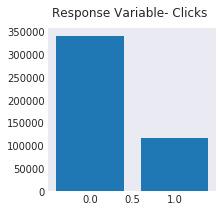

In [26]:
# plot distribution of target variable

# count variables
lbl, cnts = np.unique(y_column, return_counts=True)
print(list(zip(lbl, cnts)))

data = dict(zip(lbl, cnts))
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.bar(names, values)
fig.suptitle('Response Variable- Clicks')

In [27]:
# create column arrays for categorical features
import collections
from collections import defaultdict

start = time.time()

categorical_column_names = ['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10',
                            'c11','c12','c13','c14','c15','c16','c17','c18',
                            'c19','c20','c21','c22','c23','c24','c25','c26']
categorical_columns = defaultdict()

for i in range(14,40):
    categorical_columns[categorical_column_names[i-14]] = np.array(TrainRDD.map(lambda x: x[i]).collect())
    
print(f'... completed job in {time.time() - start} seconds.')

... completed job in 2098.3520171642303 seconds.


In [ ]:
# Observe length and first several observations of our data
print(len(categorical_columns['c1']))
print(categorical_columns['c1'][:30])
print(len(categorical_columns['c26']))
print(categorical_columns['c26'][:30])

### 3.3: Plot Distributions Of Categorical Variables

... completed job in 0.322359561920166 seconds.


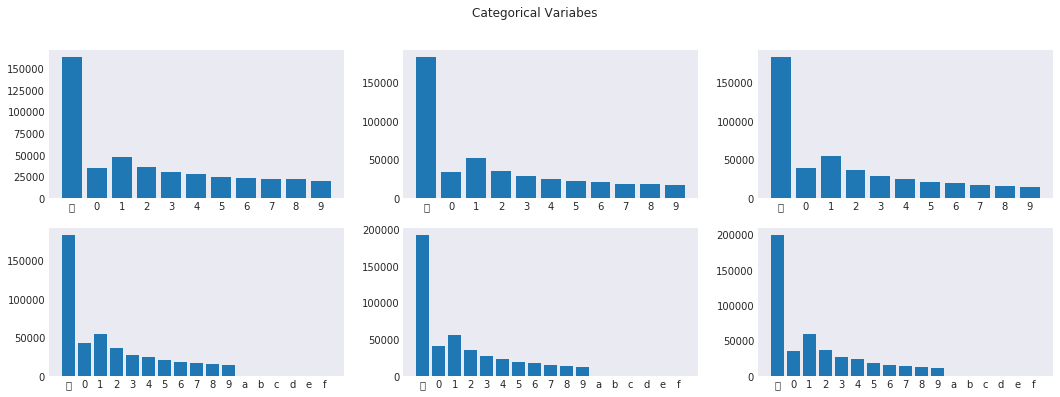

In [31]:
# Plot the distributions of our categorical variables (1 of 3)
start = time.time()
names = []
values = []

# count variables
for i in range(6):
    lbl, cnts = np.unique(categorical_columns[categorical_column_names[i]], return_counts=True)
    data = dict((zip(lbl, cnts)))
    names.append(list(data.keys()))
    values.append(list(data.values()))
#     print(names, values)
    
fig, axs = plt.subplots(2, 3, figsize=(18, 6), sharey=False)

axs[0,0].bar(names[0], values[0])
axs[0,1].bar(names[1], values[1])
axs[0,2].bar(names[2], values[2])
axs[1,0].bar(names[3], values[3])
axs[1,1].bar(names[4], values[4])
axs[1,2].bar(names[5], values[5])

fig.suptitle('Categorical Variabes')
print(f'... completed job in {time.time() - start} seconds.')

... completed job in 0.5819761753082275 seconds.


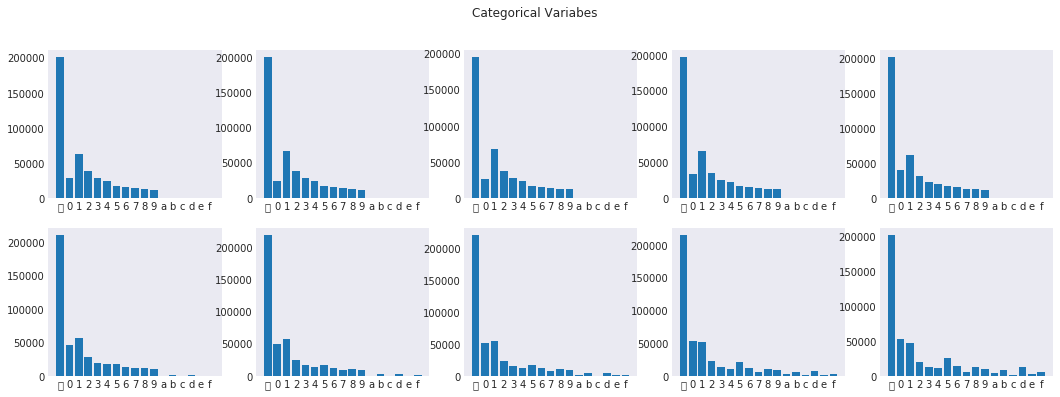

In [32]:
# Plot the distributions of our categorical variables (2 of 3)
start = time.time()
names = []
values = []

# count variables
for i in range(10):
    lbl, cnts = np.unique(categorical_columns[categorical_column_names[i+6]], return_counts=True)
    data = dict((zip(lbl, cnts)))
    names.append(list(data.keys()))
    values.append(list(data.values()))
#     print(names, values)
    
fig, axs = plt.subplots(2, 5, figsize=(18, 6), sharey=False)

axs[0,0].bar(names[0], values[0])
axs[0,1].bar(names[1], values[1])
axs[0,2].bar(names[2], values[2])
axs[0,3].bar(names[3], values[3])
axs[0,4].bar(names[4], values[4])
axs[1,0].bar(names[5], values[5])
axs[1,1].bar(names[6], values[6])
axs[1,2].bar(names[7], values[7])
axs[1,3].bar(names[8], values[8])
axs[1,4].bar(names[9], values[9])

fig.suptitle('Categorical Variabes')
print(f'... completed job in {time.time() - start} seconds.')

... completed job in 0.5310359001159668 seconds.


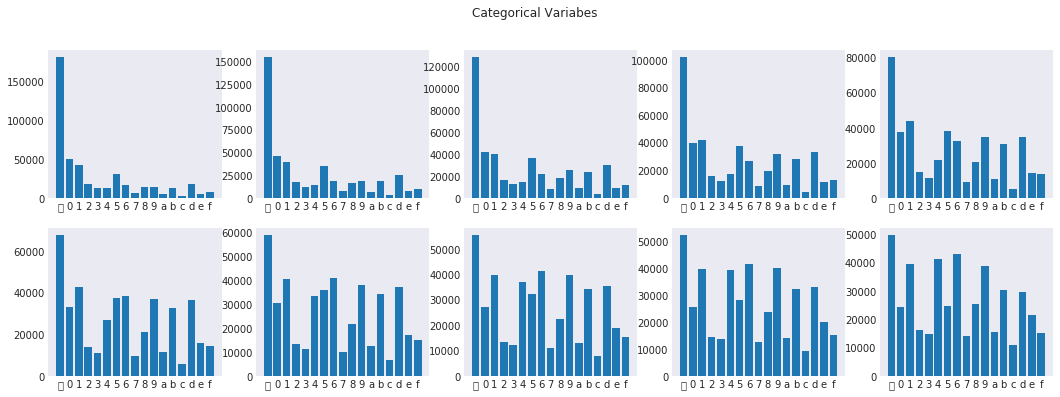

In [33]:
# Plot the distributions of our categorical variables (3 of 3)
start = time.time()
names = []
values = []

# count variables
for i in range(10):
    lbl, cnts = np.unique(categorical_columns[categorical_column_names[i+16]], return_counts=True)
    data = dict((zip(lbl, cnts)))
    names.append(list(data.keys()))
    values.append(list(data.values()))
#     print(names, values)
    
fig, axs = plt.subplots(2, 5, figsize=(18, 6), sharey=False)

axs[0,0].bar(names[0], values[0])
axs[0,1].bar(names[1], values[1])
axs[0,2].bar(names[2], values[2])
axs[0,3].bar(names[3], values[3])
axs[0,4].bar(names[4], values[4])
axs[1,0].bar(names[5], values[5])
axs[1,1].bar(names[6], values[6])
axs[1,2].bar(names[7], values[7])
axs[1,3].bar(names[8], values[8])
axs[1,4].bar(names[9], values[9])

fig.suptitle('Categorical Variabes')
print(f'... completed job in {time.time() - start} seconds.')

In [39]:
# Create column arrays for numerical features to plot in matplotlib

start = time.time()

def map_to_int(string):
    if string == "" or string == "\t" or string == "-":
        return np.nan
    else:
        return(int(string))

numeric_column_names = ['n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13']
numeric_columns = defaultdict()
for i in range(1,14):
    numeric_columns[numeric_column_names[i-1]] = np.array(TrainRDD.map(lambda x: map_to_int(x[i])).collect())
    
print(f'... completed job in {time.time() - start} seconds.')

... completed job in 1070.1579253673553 seconds.


In [40]:
print(numeric_columns['n13'][:30])

[ 4.  5.  0.  6. nan nan nan nan  1.  8.  4. nan nan  0.  5.  2.  6.  6.
 nan  9.  7.  4.  5.  8.  8.  5. nan  5.  0.  5.]


### 3.4: Plot Histograms Of Numeric Variables 

In [ ]:
# Plot histograms of numeric variables (1 of 2)
start = time.time()
names = []
values = []

# count variables
for i in range(6):
    lbl, cnts = np.unique(numeric_columns[numeric_column_names[i]], return_counts=True)
    data = dict((zip(lbl, cnts)))
    names.append(list(data.keys()))
    values.append(list(data.values()))
#     print(names, values)
    
fig, axs = plt.subplots(2, 3, figsize=(18, 6), sharey=False)

axs[0,0].bar(names[0], values[0])
axs[0,1].bar(names[1], values[1])
axs[0,2].bar(names[2], values[2])
axs[1,0].bar(names[3], values[3])
axs[1,1].bar(names[4], values[4])
axs[1,2].bar(names[5], values[5])

fig.suptitle('Numeric Variabes')
print(f'... completed job in {time.time() - start} seconds.')

In [ ]:
# Plot histograms of numeric variables (2 of 2)

start = time.time()
names = []
values = []

# count variables
for i in range(7):
    lbl, cnts = np.unique(numeric_columns[numeric_column_names[i+6]], return_counts=True)
    data = dict((zip(lbl, cnts)))
    names.append(list(data.keys()))
    values.append(list(data.values()))
#     print(names, values)
    
fig, axs = plt.subplots(2, 4, figsize=(18, 6), sharey=False)

axs[0,0].bar(names[0], values[0])
axs[0,1].bar(names[1], values[1])
axs[0,2].bar(names[2], values[2])
axs[0,3].bar(names[3], values[3])
axs[1,0].bar(names[4], values[4])
axs[1,2].bar(names[5], values[5])
axs[1,3].bar(names[6], values[6])

fig.suptitle('Numeric Variabes')
print(f'... completed job in {time.time() - start} seconds.')

*Note*: The EDA beyond this point was performed on a smaller subset of the data as illustrative of the techniques that could be used. Time permitting, this EDA will be extended to the entire dataset.

### 3.5: Obtain Count of NaNs In Numeric And Nulls In Categoric Features 

In [4]:
from pyspark.sql import SparkSession
app_name = "hw5_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
df = spark.read.format('csv')\
               .options(delimiter = '\t', header='true', inferSchema='true')\
               .load('Testing1000.txt')

In [5]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| f1| f2| f3| f4| f5| f6| f7| f8| f9|f10|f11|f12|f13|f14|f15|f16|f17|f18|f19|f20|f21|f22|f23|f24|f25|f26|f27|f28|f29|f30|f31|f32|f33|f34|f35|f36|f37|f38|f39|f40|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|  0|458|  0|230|213| 41|248| 39|  0| 39|458| 39|775|213|  0|  0| 33| 33|  0|122|  0|  0|  0|  0|  0| 33|  0|  0|  0| 33|  0|  0|498|498| 33|815|  0| 33|498|498|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+



### 3.6: Obtain Count Of "Clean" Records (No NaNs or Nulls) 

In [6]:
clean_df = df.dropna()
clean_df.count()

13

In [8]:
import pandas as pd
pd.DataFrame(clean_df.take(10), columns=clean_df.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
f1,1,0,0,0,0,1,0,0,0,0
f2,0,4,3,0,1,2,1,45,1,0
f3,127,0,0,1,0,0,0,0,3,1
f4,1,128,27,2,133,3,109,16,2,46
f5,3,42,26,14,0,1,4,5,2,15
f6,1683,7,25,2109,495,358,10,24,59,1481
f7,19,44,37,43,63,7,0,5,2,54
f8,26,4,14,7,1,32,32,51,8,4
f9,17,44,22,18,27,26,26,5,12,46
f10,475,42,108,43,28,228,562,276,352,66


#### 3.7: Obtain Mean, Standard Deviation, Min and Max Of Numeric Features Using Standard Functions

In [9]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
f1,1000,0.205,0.4039036248143093,0,1
f2,542,3.841328413284133,10.170665134870028,0,88
f3,1000,128.831,435.30095262744214,-2,3472
f4,770,37.044155844155846,319.49719620964987,0,8457
f5,787,8.050825921219822,10.200781225580299,0,87
f6,959,13868.544316996871,50735.876887820305,0,893008
f7,752,157.34840425531914,369.50058193555344,0,4638
f8,961,13.748178980228928,44.72302561453027,0,825
f9,1000,13.511,16.149448401839734,0,289


#### 3.8: Obtain Scatter Plot Of Correlation Of Numeric Features

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


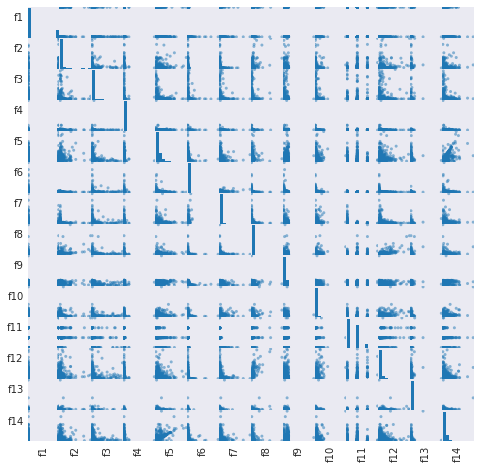

In [10]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

## Section 4 - Implementation 

### 4.0: Logistic Regression Implementation

To ensure that the we have an understanding of the impact of the numerical variables and the categorical variables on the Click-Through prediction accuracy, we decided to develop two home-grown logistic regression algorithms. 

The first algorithm takes all the numerical variables columns[1:14] and does logistic regression on these variables while the second algorithm takes both the numerical and categorical variables and does logistic regression. The goal is to evaluate the increase in accuracy as we include the categorical variables in the logistic regression.

To implement logistic regression with gradient descent in a scalable manner/approach, the goal was to ensure that we maintain the same dense representation as we have in the dataset; i.e., be as linear as we can in the space complexity of the problem. This was achieved using Accumulators as counters for the Weights matrix (the array of weight coefficients were stored as `numpy` arrays and initilized to 0's in the Accumulator). While iterating through every row in the RDD, we created a new `DefCost` variable that kept the values of the additional error $y-\hat{y}$ multiplied by the $x_i$ term. This was then added to the already initialized accumulator (since accumulators can act on mathematical equations that are either commutative and/or associative in nature). This allowed us to keep a shared variable that was updated by every RDD in every partition. 

This we believe saves large on space complexity because rather than having a sparse matrix and doing sparse matrix multiplication we are instead maintaining the initial dense format of the dataset and only expanding to a denser matrix on the accumulator with every row.

**Some Core Course Concepts Utilized in this Section**:

(1) *Accumulators/Commutative and Associative Mathematical Equations/Operations*:

Accumulators are shared variables that allows update from multiple Spark workers. They are used for mathematical equations that demonstrate Commutativity and Associativity. 

- Example of Commutativity is 3+4 = 4+3. This is the case we are dealing with in the addition of individual weights associated with each 
column in a sparse matrix dataset.
- Example of Associativity is (2+3)+4 = 2+(3+4). Accumulators were used to save and increment numpy arrays of 
beta coefficients during the gradient descent calculation.

(2) *One Hot Encoding (Not)*:

To ensure scalability and prevent shuffling of large amount of data over the network our goal was to maintain the compactness of the dataset until computation was about to be done. Thus, after hashing, we optimized the algorithm to run without the need for one hot encoding of the categorical features. This definitely saved on space since one hot encoding of our features would have created an additional 250 columns that mostly consist of 0's.

(3) *Gradient-Descent / Batch vs Stochastic*:

Gradient descent was used because the minimization of the log loss of the sigmoid function results to a convex optimization problem that has a global minimum. By using the gradient descent with log loss we ensure that we will eventually converge to a local minimum the more iterations we make over the entire dataset.

Because we are going through the entire dataset at each epoch before we make a descent along the direction of maximum gradient, the algorithm for now is quite slow. However, to implement this on a larger scale we would need to use either a batch gradient descent methodology or a stochastic gradient descent methodology.

The batch gradient descent methodology makes changes to the beta coeffients/weights after receiving a specified number of batches, while the stochastic gradient descent takes a randomized sample from the dataset at every iteration rather than just taking the next row.

### 4.1: Logistic Regression On Numerical Features

The logistic regression function below takes as input the `NonNumericRDD` from section 1.4, a learning rate and initial weights. It returns the final weights for that epoch as well as the loss.

Accumulators are used to keep track of weights and changes in the weight during the epoch.

This is a scalable approach and parallelizable. we ensured that there are no nested loops within any of the functions.
To ensure faster training and for scaling we can use batch gradient descent/stochastic gradient descent so that we make more updates per epoch.

In [75]:
def LogisticRegressionEvaluator(NonNumericRDD, initialWeights, lr):
    
    
    from pyspark.accumulators import AccumulatorParam
    class FloatAccumulatorParam(AccumulatorParam):
        """
        Custom accumulator for use in page rank to keep track of various masses.
        IMPORTANT: accumulators should only be called inside actions to avoid duplication.
        We stringly recommend you use the 'foreach' action in your implementation below.
        """
        import numpy as np
        def zero(self, value):
            return value
        def addInPlace(self, val1, val2):
            return (val1 + val2)
    mmAccum = sc.accumulator(initialWeights, FloatAccumulatorParam())
    """ This function does the logistic regression and returns updated weights """
    
    def sigmoidFunction(z):
        """ This is the Sigmoid Function """
    
        yhat = 1.0/(1.0 + np.exp(-1 * z))
        return (yhat)

    
    def LogisticLoss(y, yhat):
        """ This computes the Logistic Loss Function """
    
        TotalLoss = ((-y*np.log(yhat)) + ((1-y)*np.log(1- yhat)))
        return TotalLoss
    
    
    
    def PerRowCalculation(RDDRow):
        """ The calculation made on a per row basis """
        Key = RDDRow[0]
        Value = RDDRow[1]
        realY = Value[0]
        RestY = Value[1:15]

        Y = initialWeights[0]

        for i in range(len(RestY) -1):
            Y += initialWeights[i+1] * RestY[i]
        y_hat = sigmoidFunction(Y)
        Error = (realY - y_hat)

        DefCost = [Error]
        for i in range(len(RestY) - 1):
            DefCost.append(Error*RestY[i]) 


        Loss = realY*np.log(y_hat) + (1-realY)* np.log(1-y_hat)

        return((realY, (DefCost, Loss)))
    
    
    def LossSummation(rowRDD):
        """ This calculates the loss and sums them """
        Key = rowRDD[0]
        DefCostLoss = rowRDD[1]
        Loss = rowRDD[1][1]

        return Loss
    
    
    def AccumulatingArrays(rowRDD):
        """ This function is to accumulate the Accumulator Function """

        Key = rowRDD[0]
        DefCostLoss = rowRDD[1]
        Loss = rowRDD[1][1]
        DefCost = np.array(rowRDD[1][0])

        mmAccum.add(DefCost)
    
    ################################################################
    ########### Logistic Regression Function Begins Here ###########
    
    Update = NonNumericRDD.map(PerRowCalculation).cache()
    FinalLoss = -1* Update.map(LossSummation).mean()
    Update.foreach(AccumulatingArrays)
    m = Update.count()
    FinalWeight = initialWeights - ((1/m)* lr * (mmAccum.value))
    
    return ((FinalWeight,FinalLoss))

In [76]:
LogisticRegressionEvaluator(NonNumericRDD,initialWeights,0.7)

(array([ 1.70179298e-01,  1.84573500e-01, -1.33481739e-02,  6.05789582e-01,
         2.26955631e-01,  1.30266695e+02,  5.27975144e+00,  1.45676582e-01,
         1.06650906e-02,  1.09239015e+00,  3.21860628e-02, -1.42630337e-02,
         2.73556437e-02,  2.47757845e-01]), 0.6931471805599454)

### 4.2: Evaluating Model Performance - Predicting The Accuracy

The code below was used to evaluate the performance of the new model weights obtained after one iteration on the training dataset.
The function computes $\hat{y}$ and compares with $y$. If the values are similar, it outputs a 1 for that row or a 0 is they are different. 
The code also calculates the True-positive, False-positive, True-negative, False-negative as well as the recall, precision and ROC values.

In [106]:
def AccuracyPrediction(Weights, NonNumericRDD):
    
    """ This function computes the Accuracy given the weights and RDD """

    def PredictTest(RDDRow):
        Key = RDDRow[0]
        Value = RDDRow[1]
        realY = Value[0]
        RestY = Value[1:15]

        Y = Weights[0]

        for i in range(len(RestY) -1):
            Y += initialWeights[i+1] * RestY[i]
        y_hat = round(sigmoidFunction(Y))

        if y_hat == realY:
            Z = 1
        else:
            Z = 0


        return (((realY, y_hat),Z))
    
    ######### Accuracy Computation and Return ###########
    Yeah = NonNumericRDD.map(PredictTest).values().cache()
    Accuracy = Yeah.sum()/ Yeah.count()
    
    ################ TP, TN, FP, FN, Precision, Recall, ROC ####################
    Yeah2 = NonNumericRDD.map(PredictTest).keys().cache()
    TP = Yeah2.filter(lambda x: (x[0][0] == x[0][1]) & ( x[0][0]== 1)).count()
    TN = Yeah2.filter(lambda x: (x[0][0] == x[0][1]) & ( x[0][0]== 0)).count()
    FN = Yeah2.filter(lambda x: (x[0][0] != x[0][1]) & ( x[0][0]== 1)).count()
    FP = Yeah2.filter(lambda x: (x[0][0] != x[0][1]) & ( x[0][0]== 0)).count()
    
    Precision = TP/(TP + FP)
    Recall = TP/(TP + FN)
    
    ROC = 2* Precision*Recall/(Precision + Recall)
    
    return (Accuracy, ROC)

The accuracy of the model after running the logistic regression algorithm is around 26%

In [89]:
YY = [ 1.70179298e-01,  1.84573500e-01, -1.33481739e-02,  6.05789582e-01,
         2.26955631e-01,  1.30266695e+02,  5.27975144e+00,  1.45676582e-01,
         1.06650906e-02,  1.09239015e+00,  3.21860628e-02, -1.42630337e-02,
         2.73556437e-02,  2.47757845e-01]

AccuracyPrediction(YY,NonNumericRDD)

0.2568867173441232

### 4.3: Logistic Regression On Categorical And Numerical Features

The logistic regression function below takes as input the `NonNumericRDD` from section 1.4, a learning rate and initial weights. It returns the Final weights for that Epoch as well as the loss. 

Accumulators are used to keep track of weights and changes in the weight during the epoch.

This is a scalable approach and parallelizable. we ensured that there are no nested loops within any of the functions. To ensure faster training and for scaling we can use batch gradient descent/stochastic gradient descnet so that we make more updates per epoch.

In [96]:
initialWeights = (np.ones(289))

In [100]:
def LogisticRegressionEvaluator2(NonNumericRDD, initialWeights, lr):
    
    
    from pyspark.accumulators import AccumulatorParam
    class FloatAccumulatorParam(AccumulatorParam):
        """
        Custom accumulator for use in page rank to keep track of various masses.
        IMPORTANT: accumulators should only be called inside actions to avoid duplication.
        We stringly recommend you use the 'foreach' action in your implementation below.
        """
        import numpy as np
        def zero(self, value):
            return value
        def addInPlace(self, val1, val2):
            return (val1 + val2)
    mmAccum = sc.accumulator(initialWeights, FloatAccumulatorParam())
    """ This function does the logistic regression and returns updated weights """
    
    def sigmoidFunction(z):
        """ This is the Sigmoid Function """
    
        yhat = 1.0/(1.0 + np.exp(-1 * z))
        return (yhat)

    
    def LogisticLoss(y, yhat):
        """ This computes the Logistic Loss Function """
    
        TotalLoss = ((-y*np.log(yhat)) + ((1-y)*np.log(1- yhat)))
        return TotalLoss
    

#################### Needs to Change for including Categorical Variables #################
    
    def PerRowCalculation(RDDRow):
        """ The calculation made on a per row basis """
        Key = RDDRow[0]
        Value = RDDRow[1]
        realY = Value[0]
        RestY = Value[1:15]
        CatY = Value[15:]

        Y = initialWeights[0]

        for i in range(len(RestY) -1):
            Y += initialWeights[i+1] * RestY[i]
        
        for index,value in enumerate(CatY):
            Y += initialWeights[14+(value) + (index*11)]
            
        y_hat = sigmoidFunction(Y)
        Error = (realY - y_hat)

        DefCost = [Error]
        for i in range(len(RestY) - 1):
            DefCost.append(Error*RestY[i]) 
            
        for index,value in enumerate(CatY):
            for ii in range(0,11):
                if ii != value:
                    DefCost.append(0)
                elif ii == value:
                    DefCost.append(Error*1)
                    

        if y_hat == 0:   ##Prevent us from having a -inf value
            Loss =  (1-realY)* np.log(1-y_hat)
        elif y_hat ==1:  ## Prevent us from having a -inf value
            Loss = realY*np.log(y_hat) 
        else:
            Loss = realY*np.log(y_hat) + (1-realY)* np.log(1-y_hat)

        return((realY, (DefCost, Loss)))
#########################################################################################    
    
    def LossSummation(rowRDD):
        """ This calculates the loss and sums them """
        Key = rowRDD[0]
        DefCostLoss = rowRDD[1]
        Loss = rowRDD[1][1]

        return Loss
    
    
    def AccumulatingArrays(rowRDD):
        """ This function is to accumulate the Accumulator Function """

        Key = rowRDD[0]
        DefCostLoss = rowRDD[1]
        Loss = rowRDD[1][1]
        DefCost = np.array(rowRDD[1][0])

        mmAccum.add(DefCost)
    
    ################################################################
    ########### Logistic Regression Function Begins Here ###########
    
    Update = NonNumericRDD.map(PerRowCalculation).cache()
    FinalLoss = -1* Update.map(LossSummation).mean()
    Update.foreach(AccumulatingArrays)
    m = Update.count()
    FinalWeight = initialWeights - ((1/m)* lr * (mmAccum.value))
    
    return ((FinalWeight,FinalLoss))

In [101]:
LogisticRegressionEvaluator2(NonNumericRDD,initialWeights,0.7)

(array([  1.51966932,   1.53039054,   0.98597392,   3.19532361,
          1.71228969, 293.25008743,  13.34180519,   1.38499477,
          1.01294389,   3.63184942,   1.17587723,   1.03227896,
          1.11209385,   1.76742003,   0.99976181,   0.99949003,
          0.99949613,   0.99950224,   0.99950071,   1.00162459,
          1.01630847,   1.13166483,   1.22814606,   1.12380604,
          1.01526867,   1.2347238 ,   0.9995282 ,   0.99966714,
          1.00037866,   1.00149786,   1.00555016,   1.02217164,
          1.0428042 ,   1.05920886,   1.12304872,   1.02599034,
          1.12252653,   0.99953278,   0.99965035,   1.00060769,
          1.00195286,   1.00688617,   1.03560655,   1.05882867,
          1.10683644,   1.15235388,   1.02978766,   0.99967325,
          0.99949003,   0.99949003,   0.99949155,   0.99949766,
          0.99950377,   0.99954194,   1.0001023 ,   1.51822796,
          1.00004581,   0.99950529,   1.06274051,   0.99949003,
          0.99949003,   0.99949003,   0.

In [102]:
def AccuracyPrediction2(initialWeights, NonNumericRDD):
    
    """ This function computes the Accuracy given the weights and RDD for Categorical and Numerical Variables """
    
    

    def PredictTest(RDDRow):
        Key = RDDRow[0]
        Value = RDDRow[1]
        realY = Value[0]
        RestY = Value[1:15]
        CatY = Value[15:]

        Y = Weights[0]
        
        """ This calculates the (Beta*X) values for the Numerical features """
        for i in range(len(RestY) -1):
            Y += initialWeights[i+1] * RestY[i]
            
        """ This calculates the (Beta*1) values for the Categorical features """
        for index,value in enumerate(CatY):
            Y += (initialWeights[14+(value) + (index*11)] *1)
        
        y_hat = round(sigmoidFunction(Y))

        if y_hat == realY:
            Z = 1
        else:
            Z = 0


        return (((realY, y_hat),Z))
    
    ######### Accuracy Computation and Return ###########
    Yeah = NonNumericRDD.map(PredictTest).values().cache()
    Accuracy = Yeah.sum()/ Yeah.count()
    
    ################ TP, TN, FP, FN, Precision, Recall, ROC ####################
    Yeah2 = NonNumericRDD.map(PredictTest).keys().cache()
    TP = Yeah2.filter(lambda x: (x[0][0] == x[0][1]) & ( x[0][0]== 1)).count()
    TN = Yeah2.filter(lambda x: (x[0][0] == x[0][1]) & ( x[0][0]== 0)).count()
    FN = Yeah2.filter(lambda x: (x[0][0] != x[0][1]) & ( x[0][0]== 1)).count()
    FP = Yeah2.filter(lambda x: (x[0][0] != x[0][1]) & ( x[0][0]== 0)).count()
    
    Precision = TP/(TP + FP)
    Recall = TP/(TP + FN)
    
    ROC = 2* Precision*Recall/(Precision + Recall)
    
    return (Accuracy)

In [103]:
YY = [  1.51966932,   1.53039054,   0.98597392,   3.19532361,
          1.71228969, 293.25008743,  13.34180519,   1.38499477,
          1.01294389,   3.63184942,   1.17587723,   1.03227896,
          1.11209385,   1.76742003,   0.99976181,   0.99949003,
          0.99949613,   0.99950224,   0.99950071,   1.00162459,
          1.01630847,   1.13166483,   1.22814606,   1.12380604,
          1.01526867,   1.2347238 ,   0.9995282 ,   0.99966714,
          1.00037866,   1.00149786,   1.00555016,   1.02217164,
          1.0428042 ,   1.05920886,   1.12304872,   1.02599034,
          1.12252653,   0.99953278,   0.99965035,   1.00060769,
          1.00195286,   1.00688617,   1.03560655,   1.05882867,
          1.10683644,   1.15235388,   1.02978766,   0.99967325,
          0.99949003,   0.99949003,   0.99949155,   0.99949766,
          0.99950377,   0.99954194,   1.0001023 ,   1.51822796,
          1.00004581,   0.99950529,   1.06274051,   0.99949003,
          0.99949003,   0.99949003,   0.99949003,   0.99949003,
          0.99949003,   1.0127356 ,   1.44315189,   0.9995114 ,
          0.99949003,   1.01499231,   0.99949919,   0.99952667,
          0.99982441,   1.0054387 ,   1.00750761,   1.0232374 ,
          1.09789358,   1.17500191,   1.13040822,   1.0612396 ,
          0.99994198,   0.99949003,   0.99949003,   0.99949766,
          0.99950377,   0.99951751,   0.99966256,   1.00128257,
          1.51630716,   1.00031148,   0.99956484,   0.99949003,
          0.99949003,   0.99949003,   0.99949003,   0.99949003,
          0.99949003,   0.99949003,   0.99949003,   1.45790601,
          1.06125334,   0.99949003,   1.03116947,   0.99949155,
          0.99954499,   0.9999771 ,   1.00203989,   1.00617465,
          1.02407106,   1.0697076 ,   1.28112072,   1.08492742,
          1.01634512,   1.0048417 ,   0.99949308,   0.99950988,
          0.99998779,   1.00489819,   1.00648919,   1.01263635,
          1.09522461,   1.21768549,   1.12874851,   1.0450548 ,
          1.21384389,   0.9995282 ,   0.99968241,   1.00038172,
          1.00151923,   1.00564788,   1.02241899,   1.04324547,
          1.07626397,   1.12573295,   1.02630487,   1.00196355,
          0.99949308,   0.99949003,   0.99960149,   1.00464473,
          1.00633497,   1.01325932,   1.09086083,   1.23363209,
          1.12351747,   1.04177204,   0.99949461,   0.99949003,
          0.99949003,   0.99949003,   0.99949461,   0.99960149,
          1.00276668,   1.03422015,   1.46448528,   1.00759311,
          1.00844358,   1.01044225,   0.99949003,   0.99966409,
          1.00016796,   1.00191316,   1.00664035,   1.03516986,
          1.07337514,   1.19144016,   1.15051706,   1.04574953,
          1.17508436,   0.99952667,   0.99966409,   1.00051608,
          1.0014887 ,   1.00608457,   1.02440698,   1.05286168,
          1.08807735,   1.13837236,   1.02848677,   0.99949003,
          0.99949003,   0.99949003,   0.99949003,   0.99949003,
          0.99949003,   0.99949003,   1.24157944,   1.13739364,
          1.12349609,   1.01567024,   1.00340797,   0.99949155,
          0.99962592,   0.99985953,   1.0011482 ,   1.00519135,
          1.03174968,   1.06293747,   1.23738818,   1.14976737,
          1.02400236,   1.22602982,   0.99949003,   0.99949308,
          0.99950682,   0.99957553,   0.99968241,   1.00393168,
          1.02520247,   1.23963115,   1.01990882,   1.00211777,
          1.22447089,   0.99949003,   0.99949003,   0.99949003,
          0.99949003,   0.99949003,   0.99949003,   0.99949003,
          1.29468846,   0.99949003,   0.99949003,   1.1985462 ,
          0.99952972,   0.99976028,   1.00044737,   1.00164749,
          1.00583263,   1.02313968,   1.04851316,   1.07850236,
          1.13238246,   1.02626823,   1.40026371,   0.99949003,
          0.99949003,   0.99949003,   0.99949003,   0.99949003,
          0.99949003,   0.99964882,   1.11873684,   0.99949003,
          0.99949003,   0.99949003,   0.99949003,   0.99949003,
          0.99949003,   0.99949003,   0.99949003,   0.99949003,
          1.062797  ,   1.41432921,   1.00465847,   1.03635471,
          1.05952035,   0.9995282 ,   0.99960912,   1.00050692,
          1.00149633,   1.00422942,   1.02657818,   1.06898387,
          1.21152916,   1.1137959 ,   1.02879214,   1.22451975,
          0.99949003,   0.99949003,   0.99949003,   0.99949003,
          0.99949461,   0.99949613,   1.02290148,   1.27032424,
          1.0003695 ,   0.99950377,   1.25682826,   0.99949155,
          0.99963355,   1.00024583,   1.0009604 ,   1.00284761,
          1.01885681,   1.03902062,   1.08595653,   1.08335933,
          1.0273691 ]
AccuracyPrediction(YY,NonNumericRDD)

0.287969375402166

## Section 5 - Core Course Concepts Used For Algorithm And Data Preparation

### 5.0: Summary
(1) *Hashing* -- 

Although we did not touch on this concept in depth in class, the hashing function as used here is the function that enables us to reduce the cardinality of the categorical variables from several thousands to only 10 or as many as we deem fit. 

Hashing here was implemented using an home grown algorithm.

Home-Grown Hashing Function Algorithm:

The hashing function uses the co-occurence count of each feature within a column with the click outcome "1" divided by the total count of co-occurence of the feature. This results in what we call a "co-occurence count of importance". Basically because this is normalized by the overall count, the values are always between 0 and 1, with 1 showing that the feature is very important (meaning everytime this feature occured we also had the occurence of a count), and 0 meaning the feature is not important at all (meaning everytime this feature occured we did not see the occurence of a count).
The hashing function enables us to reduce cardinality and also go from a sparse distribution to a denser representation of the categorical variables.

By choosing an hashing from 1-10 we went from a very high dimensional (cardinal) problem to a lower dimensionality. One can argue that even 10 categories for every categorical column is still a lot, will it be more practical to have the categories be 5 instead of 10. Definitely, if computation resource is a bottleneck and given that we know there is some similarity amongst some of the features within a column we can certainly divide the categorical varaibles into 5 classes. Also note that hashing, as discussed previously, enables us to make the data less sparse.

(2) *Caching and Broadcasting* -- 

Entities that were cached and broadcasted included:

- small array containing Mean and Standard Deviations
- dictionary containing feature importance of the categorical variables`NonNumericRDD`

Finding the mean and standard deviation for the `trainRDD` (10GB dataset) involved going through the entire dataset. However, mean and standard deviation are supposed to be utilized for mean-normalizing only the `TrainRDD` and the `TestRDD2`. Thus an important concept here is to do the mean and standard deviation calculation **first** and then cache these values. Because the array generated containing both the mean and standard deviation is small, one can broadcast these values for use in mean-normalizing the `TrainRDD` and the `TestRDD2`.

In addition, generating the dictionary containing as keys the categorical features, and as values the co-occurring feature importance, is computationally expensive. The resulting dictionary (a default dict from Python) is not large for each column. This data is thus broadcasted for use in the transformation of each column to a hashed value between 1 and 10.

Caching was also used multiple times in the initial analysis, this is because some RDDs calculated at an initial time $t_0$  still had multiple uses downstream at times $t_1$ and $t_2$. If the RDD were not cached, pyspark would need to re-evaluate the RDD everytime a call was made to that RDD. Caching is especially useful when RDD computation is expensive (`NonNumericRDD`s - These are computationally expensive calculations). Without caching, every call to these RDDs would mean re-evaluating them again.

While caching is good, it also takes away computational resource as some part of memory is allocated to the RDD. When all memory is used for caching the unused RDDs are spilled-to and stored on disk. Although having RDDs in memory ensures faster computation/evaluation than having RDDs on disk, it is still faster re-evaluating RDDs from memory then recomputing/re-evaluating the RDD. Because of the spill-to-disk problem it is definitely worth it storing in memory only RDDs that are computationally expensive to calculate. Once we are done with the RDD one should ensure to `unpersist()` the RDD to free memory space for other RDDs.

To ensure scalability one needed to ensure that RDDs were `unpersist()`ed from memory once they were no longer in use. If the RDDs were not `unpersist()`ed then it is totally conceivable that one would run out of memory space for computation and eventually RDDs would spill to disk.

(3) *Normalization* --

Normalization of features (numerical features) is extremely important especially for gradient descent. Numerical features can have widely varying ranges. The range of values (-inf to +inf). These range of values can result in Stochastic Gradient Descent taking a very long time to converge. To prevent this from occuring normalization of the numerical variables is done.

The method utilized for normalizing here was deployed on the 10GB dataset and it appears to be scalable. The process involves taking a pass through the dataset to calculate the mean and standard deviation of each numerical column and storing each of these values in a list as a set (mean, standard deviation).
Because this set is small one can then broadcast this set to the RDD partitions and do another loop through the dataset, this time only doing the mean normalization computation $(x_i - mean)/\sigma$.

Mean Normalization for SGD: Mean normalization of the numerical variables is very important for Gradient Descent because non normalized features would take a longer time to converge. To ensure that we converge faster we use mean normalization of the features using the array of mean and standard deviation values.

(4) *Accumulators/Commutative and Associative Mathematical Equations/Operations* --

Accumulators are shared variables that allows update from multiple Spark workers. They are used for mathematical equations that demonstrate commutativity and associativity. 

- Example of Commutativity: 3+4 = 4+3 - This is the case we are dealing with in the addition of individual weights associated with each column in a sparse matrix dataset) 
- Example of Associativity: (2+3)+4 = 2+(3+4). Accumulators were used to save and increment numpy arrays of beta coeeficients during the gradient descent calculation.

(5) *One Hot Encoding (Not)* --

To ensure scalability and prevent shuffling of large amount of data over the network our goal was to maintain the compactness of the dataset until computation was about to be done. Thus, after hashing, we optimized the algorithm to run without the need for one hot encoding of the categorical features. This definitely saved on space since one hot encoding of our features would have created an additional 250 columns that mostly consist of 0's.

(6) *Gradient-Descent/Batch vs Stochastic* --

Gradient descent was used because the minimization of the log loss of the sigmoid function results in a convex optimization problem that has a global minimum. By using the gradient descent with log loss we ensure that we will eventually converge to a local minimum the more iterations we make over the entire dataset.

Because we are going through the entire dataset at each epoch before we make a descent along the direction of maximum gradient, the algorithm for now is quite slow. However, to implement this on a larger scale we would need to use either a batch gradient descent methodology or a stochastic gradient descent methodology.

The batch gradient descent methodology makes changes to the beta coeffients/weights after receiving a specified number of batches while the stochastic gradient descent takes a randomized sample from the dataset at every iteration rather than just taking the next row.